In [76]:
import numpy as np
import gymnasium as gym
import sys
sys.modules['gym'] = gym
import ale_py
import torch
import torch.nn as nn
from stable_baselines3 import PPO, DQN, A2C
from huggingface_sb3 import load_from_hub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

In [77]:
from typing import Optional, Dict, Any, List, Callable

In [78]:
PONG_RAM_INDEX = {
    "ball_x":   49,
    "ball_y":   54,
    "enemy_y":  50,
    "player_y": 51,
}

BALL_X_MIN = 50
BALL_X_MAX = 208
BALL_Y_MIN = 44
BALL_Y_MAX = 207
PLAYER_Y_MIN = 38
PLAYER_Y_MAX = 203
ENEMY_Y_MIN = 0
ENEMY_Y_MAX = 208

BALL_X_MID = (BALL_X_MAX - BALL_X_MIN) / 2
BALL_Y_MID = (BALL_Y_MAX - BALL_Y_MIN) / 2

PLAYER_Y_MID = (PLAYER_Y_MAX - PLAYER_Y_MIN) / 2
ENEMY_Y_MID = (ENEMY_Y_MAX - ENEMY_Y_MIN) / 2

In [79]:
class PongSymmetryAnalyzer:
    """
    A class for analyzing symmetries in Pong environments using RAM observations.
    """
    
    def __init__(self, render_mode: Optional[str] = None):
        """
        Initialize the Pong environment with RAM observations.
        
        Args:
            render_mode: Rendering mode for the environment (None, "human", etc.)
        """
        # Register ALE environments
#         gym.register_envs(ale_py)
        
#         # Create environment with RAM observations
#         self.env = gym.make(
#             "ALE/Pong-v5",
#             obs_type="ram",
#             render_mode=render_mode,
#         )
        
        # RAM indices for extracting game state
        self.PONG_RAM_INDEX = {
            "ball_x": 49,
            "ball_y": 54,
            "enemy_y": 50,
            "player_y": 51,
        }
        
        # Game boundaries
        self.BALL_X_MIN = 50
        self.BALL_X_MAX = 208
        self.BALL_Y_MIN = 44
        self.BALL_Y_MAX = 207
        self.PLAYER_Y_MIN = 38
        self.PLAYER_Y_MAX = 203
        self.ENEMY_Y_MIN = 0
        self.ENEMY_Y_MAX = 208
        
        self.BALL_X_MID = (self.BALL_X_MAX - self.BALL_X_MIN) / 2
        self.BALL_Y_MID = (self.BALL_Y_MAX - self.BALL_Y_MIN) / 2

        self.PLAYER_Y_MID = (self.PLAYER_Y_MAX - self.PLAYER_Y_MIN) / 2
        self.ENEMY_Y_MID = (self.ENEMY_Y_MAX - self.ENEMY_Y_MIN) / 2
        
        # Store sampled states
        self.sampled_states: List[Dict[str, Any]] = []
        
    def ram_to_logic_state(
        self, 
        ram: np.ndarray, 
        prev_state: Optional[Dict[str, Any]] = None
    ) -> Dict[str, Any]:
        """
        Convert RAM observation to logical game state.
        
        Args:
            ram: 128-byte RAM vector from the environment
            prev_state: Previous logical state for velocity calculation
            
        Returns:
            Dictionary containing ball position, velocity, and paddle positions
        """
        # Extract raw positions from RAM
        ball_x_raw = int(ram[self.PONG_RAM_INDEX["ball_x"]])
        ball_y_raw = int(ram[self.PONG_RAM_INDEX["ball_y"]])
        enemy_y_raw = int(ram[self.PONG_RAM_INDEX["enemy_y"]])
        player_y_raw = int(ram[self.PONG_RAM_INDEX["player_y"]])
        
        # Check if ball exists (OCAtari condition)
        ball_exists = (ball_y_raw != 0) and (ball_x_raw > 49)
        
        # Set ball position (None if ball doesn't exist)
        ball_x = ball_x_raw if ball_exists else None
        ball_y = ball_y_raw if ball_exists else None
        
        # Paddle positions
        player_y = player_y_raw
        enemy_y = enemy_y_raw
        
        # Calculate velocity via finite differences
        if (prev_state is not None and 
            prev_state.get("ball_x") is not None and 
            ball_x is not None):
            ball_dx = ball_x - prev_state["ball_x"]
            ball_dy = ball_y - prev_state["ball_y"]
        else:
            ball_dx = 0
            ball_dy = 0
            
        return {
            "ball_x": ball_x,
            "ball_y": ball_y,
            "ball_dx": ball_dx,
            "ball_dy": ball_dy,
            "player_y": player_y,
            "enemy_y": enemy_y,
        }
    
    def sample_states(
        self, 
        num_episodes: int = 5, 
        max_steps_per_episode: int = 1000,
        model: Optional[Any] = None,
        max_states: Optional[int] = None
    ) -> List[Dict[str, Any]]:
        """
        Sample states from the environment using either a model or random policy.
        
        Args:
            num_episodes: Number of episodes to run
            max_steps_per_episode: Maximum steps per episode
            model: Optional model with select_action method. If None, uses random policy
            max_states: Maximum number of states to collect. If None, no limit
            
        Returns:
            List of logical game states
        """
        self.sampled_states = []
        
        for ep in range(num_episodes):
            ram, info = self.env.reset()
            prev_state = None
            
            for t in range(max_steps_per_episode):
                # Convert RAM to logical state
                state = self.ram_to_logic_state(ram, prev_state=prev_state)
                self.sampled_states.append(state)
                prev_state = state
                
                # Check if we've reached the maximum number of states
                if max_states is not None and len(self.sampled_states) >= max_states:
                    return self.sampled_states
                
                # Select action using model or random policy
                if model is not None:
                    # Assume model has a select_action method
                    if hasattr(model, 'select_action'):
                        action = model.select_action(ram)
                    elif hasattr(model, 'predict'):
                        action = model.predict(ram)
                    else:
                        # Try calling the model directly
                        action = model(ram)
                else:
                    # Random policy
                    action = self.env.action_space.sample()
                
                # Take step in environment
                ram, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                
                if done:
                    break
                    
        return self.sampled_states
    
    def naive_symmetry(self, state_1: Dict[str, Any], state_2: Dict[str, Any]) -> bool:
        """
        Check if two states are symmetric under naive symmetry assumption.
        Ignores scores and opponent paddle position, bins coordinates.
        
        Args:
            state_1: First game state
            state_2: Second game state
            
        Returns:
            True if states are considered symmetric, False otherwise
        """
        # Check if ball x positions and x velocities match
        ballx = state_1["ball_x"] == state_2["ball_x"]
        balldx = state_1["ball_dx"] == state_2["ball_dx"]
        
        if not ballx or not balldx:
            return False
            
        bally = state_1["ball_y"] == state_2["ball_y"]
        balldy = state_1["ball_dy"] == state_2["ball_dy"]
        playery = state_1["player_y"] == state_2["player_y"]
        
        # Case 1: Completely equal
        if bally and balldy and playery:
            return True
        
        # Case 2: Ball off screen, paddle positions symmetric
        if state_1["ball_y"] is None and state_2["ball_y"] is None:
            if (abs(state_1["player_y"] - self.BALL_Y_MID) == 
                abs(state_2["player_y"] - self.BALL_Y_MID)):
                return True
        
        # Case 3: Symmetric reflection about y-axis
        if (state_1["ball_y"] is not None and state_2["ball_y"] is not None):
            ball_y_symmetric = (abs(state_1["ball_y"] - self.BALL_Y_MID) == 
                              abs(state_2["ball_y"] - self.BALL_Y_MID))
            player_y_symmetric = (abs(state_1["player_y"] - self.PLAYER_Y_MID) == 
                                abs(state_2["player_y"] - self.PLAYER_Y_MID))
            ball_dy_opposite = state_1["ball_dy"] == -state_2["ball_dy"]
            
            if ball_y_symmetric and player_y_symmetric and ball_dy_opposite:
                return True
                
        return False
    
    def generate_similarity_matrix(
        self, 
        states: Optional[List[Dict[str, Any]]] = None,
        symmetry_function: Optional[Callable] = None
    ) -> np.ndarray:
        """
        Generate a similarity matrix for the given states using a symmetry function.
        
        Args:
            states: List of states to compare. If None, uses self.sampled_states
            symmetry_function: Function to check symmetry between two states.
                             If None, uses self.naive_symmetry
                             
        Returns:
            Binary similarity matrix where entry (i,j) is 1 if states i and j are symmetric
        """
        if states is None:
            states = self.sampled_states
            
        if symmetry_function is None:
            symmetry_function = self.naive_symmetry
            
        if len(states) == 0:
            raise ValueError("No states provided for similarity matrix generation")
            
        matrix = np.zeros((len(states), len(states)), dtype=int)
        
        for i, state_i in enumerate(states):
            for j, state_j in enumerate(states):
                matrix[i][j] = int(symmetry_function(state_i, state_j))
                
        return matrix
    
    def get_similarity_stats(self, similarity_matrix: np.ndarray) -> Dict[str, float]:
        """
        Compute statistics about the similarity matrix.
        
        Args:
            similarity_matrix: Binary similarity matrix
            
        Returns:
            Dictionary with statistics about symmetries
        """
        n = similarity_matrix.shape[0]
        total_pairs = n * (n - 1) // 2  # Exclude diagonal
        
        # Count symmetric pairs (excluding diagonal)
        symmetric_pairs = (np.sum(similarity_matrix) - n) // 2
        
        return {
            "total_states": n,
            "total_pairs": total_pairs,
            "symmetric_pairs": symmetric_pairs,
            "symmetry_ratio": symmetric_pairs / total_pairs if total_pairs > 0 else 0.0,
            "diagonal_sum": np.sum(np.diag(similarity_matrix)),
        }
    
    def close(self):
        """Close the environment."""
        # self.env.close()
        pass

In [80]:
def naive_symmetry(state_1, state_2):
    """
    In this naive treatment, I ignore: scores, opponent paddle position.
    I bin the x, y coordinates of the ball.
    I bin the y coordinate of the player paddle.
    Function returns True if: 
        - coarse x is equal in both states
        - dx is equal in both states
        - AND ball y and paddle y are equal OR equal on reflection in y=0 line
    """
    ballx = state_1["ball_x"] == state_2["ball_x"]
    balldx = state_1["ball_dx"] == state_2["ball_dx"]

    if not ballx or not balldx:
        return False
        
    bally = state_1["ball_y"] == state_2["ball_y"]
    balldy = state_1["ball_dy"] == state_2["ball_dy"] 

    playery = state_1["player_y"] == state_2["player_y"] 

    # case 1: completely equal
    # if bally:
    #     if balldy:
    #         if playery:
    #             return True

    # case 2: ball off screen. paddle flipped
    if state_1["ball_y"] is None:
        if abs(state_1["player_y"] - BALL_Y_MID) == abs(state_2["player_y"] - BALL_Y_MID):
            return True
        
    # case 2: flipped
    if state_1["ball_y"] is not None:
        if abs(state_1["ball_y"] - BALL_Y_MID) == abs(state_2["ball_y"] - BALL_Y_MID):
            if abs(state_1["player_y"] - BALL_Y_MID) == abs(state_2["player_y"] - BALL_Y_MID):
                if state_1["ball_dy"] == -state_2["ball_dy"]:
                    return True

    return False

In [81]:
def ram_to_logic_state(
    ram: np.ndarray,
    prev_state: Optional[Dict[str, Any]] = None,
) -> Dict[str, Any]:
    """
    Minimal logic-level state for ALE Pong from a 128-byte RAM vector.

    Returns:
        {
            "ball_x":   int or None,
            "ball_y":   int or None,
            "ball_dx":  int,
            "ball_dy":  int,
            "player_y": int or None,
            "enemy_y":  int or None,
        }
    """
    # Raw positions from RAM (as in OCAtari)
    ball_x_raw   = int(ram[PONG_RAM_INDEX["ball_x"]])
    ball_y_raw   = int(ram[PONG_RAM_INDEX["ball_y"]])
    enemy_y_raw  = int(ram[PONG_RAM_INDEX["enemy_y"]])
    player_y_raw = int(ram[PONG_RAM_INDEX["player_y"]])

    # OCAtari condition for “ball exists”
    ball_exists = (ball_y_raw != 0) and (ball_x_raw > 49)

    # If you want to treat "no ball" explicitly:
    ball_x = ball_x_raw if ball_exists else None
    ball_y = ball_y_raw if ball_exists else None

    # Paddles basically always exist when game is running;
    # if you want to mirror OCAtari, you could add checks similar to ram[50] / ram[51] ranges.
    player_y = player_y_raw
    enemy_y  = enemy_y_raw

    # Velocity via finite differences
    if prev_state is not None and prev_state.get("ball_x") is not None and ball_x is not None:
        ball_dx = ball_x - prev_state["ball_x"]
        ball_dy = ball_y - prev_state["ball_y"]
    else:
        ball_dx = 0
        ball_dy = 0

    return {
        "ball_x":   ball_x,
        "ball_y":   ball_y,
        "ball_dx":  ball_dx,
        "ball_dy":  ball_dy,
        "player_y": player_y,
        "enemy_y":  enemy_y,
    }

In [82]:
class ModelActivationExtractor:
    """
    Extract activations from different layers of trained RL models.
    Handles various model architectures robustly.
    """
    
    def __init__(self, model, model_type='ppo'):
        self.model = model
        self.model_type = model_type.lower()
        self.activations = {}
        self.hooks = []
        
    def register_hooks(self, layer_names=None):
        """Register forward hooks to capture activations with robust architecture handling."""
        def hook_fn(name):
            def hook(module, input, output):
                if isinstance(output, torch.Tensor):
                    self.activations[name] = output.detach().cpu().numpy()
                elif isinstance(output, (list, tuple)) and len(output) > 0:
                    # Handle cases where output is a tuple/list
                    if isinstance(output[0], torch.Tensor):
                        self.activations[name] = output[0].detach().cpu().numpy()
            return hook
            
        # Get the policy/q-network
        if hasattr(self.model, 'policy'):
            net = self.model.policy
            net_type = 'policy'
        elif hasattr(self.model, 'q_net'):
            net = self.model.q_net
            net_type = 'q_net'
        else:
            net = self.model
            net_type = 'unknown'
            
        print(f"Network type: {net_type}, Architecture: {type(net)}")
        
        # Handle different network architectures
        feature_extractors_found = []
        
        # Method 1: Handle ActorCriticCnnPolicy (PPO/A2C) - separate feature extractors
        if hasattr(net, 'pi_features_extractor') and net.pi_features_extractor is not None:
            self._register_cnn_hooks(net.pi_features_extractor, 'policy_features', hook_fn, layer_names)
            feature_extractors_found.append('policy_features')
            
        if hasattr(net, 'vf_features_extractor') and net.vf_features_extractor is not None:
            self._register_cnn_hooks(net.vf_features_extractor, 'value_features', hook_fn, layer_names)
            feature_extractors_found.append('value_features')
        
        # Method 2: Handle shared features_extractor (PPO/A2C/DQN)
        if hasattr(net, 'features_extractor') and net.features_extractor is not None:
            self._register_cnn_hooks(net.features_extractor, 'shared_features', hook_fn, layer_names)
            feature_extractors_found.append('shared_features')
        
        # Method 3: Handle DQN QNetwork structure
        if self.model_type in ['dqn', 'qrdqn']:
            if hasattr(self.model, 'q_net') and self.model.q_net is not None:
                q_net = self.model.q_net
                
                # Check if q_net has features_extractor (DQN structure)
                if hasattr(q_net, 'features_extractor') and q_net.features_extractor is not None:
                    self._register_cnn_hooks(q_net.features_extractor, 'q_features', hook_fn, layer_names)
                    feature_extractors_found.append('q_features')
                
                # Register hooks for q_net layers (final Q-value layers)
                if hasattr(q_net, 'q_net') and q_net.q_net is not None:
                    self._register_final_layers(q_net.q_net, 'q_net', hook_fn, layer_names)
                elif isinstance(q_net, nn.Sequential):
                    self._register_final_layers(q_net, 'q_net', hook_fn, layer_names)
        
        if not feature_extractors_found:
            print("Warning: Could not find any feature extractors in model architecture")
            print("Model structure:")
            print(net)
            # Try to auto-discover layers
            self._auto_discover_layers(net, hook_fn, layer_names)
            
        # Register hooks for final layers (action, value, q-networks)
        self._register_final_layer_hooks(net, hook_fn, layer_names)
        
        print(f"Total hooks registered: {len(self.hooks)}")
        print(f"Feature extractors found: {feature_extractors_found}")
        
    def _register_cnn_hooks(self, feature_extractor, prefix, hook_fn, layer_names):
        """Register hooks for a CNN feature extractor."""
        # Handle NatureCNN structure (both DQN and PPO use this)
        if hasattr(feature_extractor, 'cnn'):
            cnn_layers = feature_extractor.cnn
            print(f"Found CNN layers in {prefix} with {len(cnn_layers)} layers")
            
            for i, layer in enumerate(cnn_layers):
                if isinstance(layer, (nn.Conv2d, nn.Linear, nn.ReLU, nn.MaxPool2d, nn.Flatten)):
                    name = f'{prefix}_cnn_{i}_{layer.__class__.__name__}'
                    if layer_names is None or name in layer_names:
                        hook = layer.register_forward_hook(hook_fn(name))
                        self.hooks.append(hook)
                        print(f"  Registered hook for {name}")
        
        # Handle linear layers in feature extractor
        if hasattr(feature_extractor, 'linear'):
            linear_layers = feature_extractor.linear
            print(f"Found linear layers in {prefix} with {len(linear_layers)} layers")
            
            for i, layer in enumerate(linear_layers):
                if isinstance(layer, (nn.Linear, nn.ReLU)):
                    name = f'{prefix}_linear_{i}_{layer.__class__.__name__}'
                    if layer_names is None or name in layer_names:
                        hook = layer.register_forward_hook(hook_fn(name))
                        self.hooks.append(hook)
                        print(f"  Registered hook for {name}")
    
    def _register_final_layers(self, layer_sequence, prefix, hook_fn, layer_names):
        """Register hooks for final layers (q_net, action_net, value_net)."""
        if isinstance(layer_sequence, nn.Sequential):
            for i, layer in enumerate(layer_sequence):
                if isinstance(layer, (nn.Linear, nn.ReLU)):
                    name = f'{prefix}_{i}_{layer.__class__.__name__}'
                    if layer_names is None or name in layer_names:
                        hook = layer.register_forward_hook(hook_fn(name))
                        self.hooks.append(hook)
                        print(f"  Registered hook for {name}")
        elif isinstance(layer_sequence, (nn.Linear, nn.ReLU)):
            # Single layer
            name = f'{prefix}_{layer_sequence.__class__.__name__}'
            if layer_names is None or name in layer_names:
                hook = layer_sequence.register_forward_hook(hook_fn(name))
                self.hooks.append(hook)
                print(f"  Registered hook for {name}")
    
    def _register_final_layer_hooks(self, net, hook_fn, layer_names):
        """Register hooks for final action and value layers."""
        # Action network (policy head)
        if hasattr(net, 'action_net') and net.action_net is not None:
            name = f'action_net_{net.action_net.__class__.__name__}'
            if layer_names is None or name in layer_names:
                hook = net.action_net.register_forward_hook(hook_fn(name))
                self.hooks.append(hook)
                print(f"  Registered hook for {name}")
                
        # Value network (critic head)
        if hasattr(net, 'value_net') and net.value_net is not None:
            name = f'value_net_{net.value_net.__class__.__name__}'
            if layer_names is None or name in layer_names:
                hook = net.value_net.register_forward_hook(hook_fn(name))
                self.hooks.append(hook)
                print(f"  Registered hook for {name}")
        
        # Q-network (DQN head) - check if it's at the top level
        if hasattr(net, 'q_net') and net.q_net is not None and not hasattr(net, 'features_extractor'):
            # This is likely the final q_net layer
            self._register_final_layers(net.q_net, 'q_output', hook_fn, layer_names)
        
        # For PPO/A2C: look for mlp_extractor (though this one is empty in your case)
        if hasattr(net, 'mlp_extractor') and net.mlp_extractor is not None:
            mlp = net.mlp_extractor
            
            # Policy MLP
            if hasattr(mlp, 'policy_net') and mlp.policy_net is not None and len(mlp.policy_net) > 0:
                for i, layer in enumerate(mlp.policy_net):
                    if isinstance(layer, (nn.Linear, nn.ReLU)):
                        name = f'mlp_policy_{i}_{layer.__class__.__name__}'
                        if layer_names is None or name in layer_names:
                            hook = layer.register_forward_hook(hook_fn(name))
                            self.hooks.append(hook)
                            print(f"  Registered hook for {name}")
            
            # Value MLP  
            if hasattr(mlp, 'value_net') and mlp.value_net is not None and len(mlp.value_net) > 0:
                for i, layer in enumerate(mlp.value_net):
                    if isinstance(layer, (nn.Linear, nn.ReLU)):
                        name = f'mlp_value_{i}_{layer.__class__.__name__}'
                        if layer_names is None or name in layer_names:
                            hook = layer.register_forward_hook(hook_fn(name))
                            self.hooks.append(hook)
                            print(f"  Registered hook for {name}")
    
    def _auto_discover_layers(self, net, hook_fn, layer_names):
        """Auto-discover layers if standard patterns fail."""
        print("Attempting auto-discovery of layers...")
        
        def register_if_target_layer(module, name):
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.ReLU, nn.MaxPool2d, nn.Flatten)):
                hook_name = f'auto_{name}_{module.__class__.__name__}'
                if layer_names is None or hook_name in layer_names:
                    hook = module.register_forward_hook(hook_fn(hook_name))
                    self.hooks.append(hook)
                    print(f"  Auto-discovered: {hook_name}")
        
        # Walk through all named modules
        for name, module in net.named_modules():
            if name:  # Skip the root module (empty name)
                register_if_target_layer(module, name.replace('.', '_'))
    
    def extract_activations(self, states):
        """Extract activations for a batch of states."""
        self.activations.clear()
        
        # Convert states to tensor
        if isinstance(states, np.ndarray):
            states_tensor = torch.FloatTensor(states)
        else:
            states_tensor = torch.FloatTensor(np.array(states))
            
        # Ensure correct shape (batch_size, channels, height, width)
        if len(states_tensor.shape) == 3:
            states_tensor = states_tensor.unsqueeze(0)
        if states_tensor.shape[-1] == 3:  # If channels last
            states_tensor = states_tensor.permute(0, 3, 1, 2)
            
        # Normalize to [0, 1] if needed
        if states_tensor.max() > 1.0:
            states_tensor = states_tensor / 255.0
            
        with torch.no_grad():
            try:
                if self.model_type in ['ppo', 'a2c']:
                    # For policy gradient methods - this will trigger both policy and value feature extractors
                    self.model.policy(states_tensor)
                elif self.model_type in ['dqn', 'qrdqn']:
                    # For Q-learning methods
                    if hasattr(self.model, 'q_net'):
                        self.model.q_net(states_tensor)
                    else:
                        # Fallback
                        self.model.policy(states_tensor)
                else:
                    # Generic fallback
                    if hasattr(self.model, 'policy'):
                        self.model.policy(states_tensor)
                    elif hasattr(self.model, 'q_net'):
                        self.model.q_net(states_tensor)
                    else:
                        self.model(states_tensor)
            except Exception as e:
                print(f"Error during forward pass: {e}")
                return {}
                
        return dict(self.activations)
    
    def cleanup(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        self.activations.clear()

In [83]:
def download_models(env_name: str = "PongNoFrameskip-v4"):
    """Download pre-trained models from Hugging Face."""
    models = {}

    # pre-create environment
    # env = gym.make(env_name, render_mode="human")
    # env = ChannelFirstWrapper(env)
    env = make_atari_env(env_name, n_envs=1, env_kwargs={"render_mode": "human"})
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)

    # 4. Load with CUSTOM_OBJECTS override
    # This replaces the metadata from the file with the spaces from your current env
    custom_objects = {
        "observation_space": env.observation_space,
        "action_space": env.action_space
    }
    
    try:
        # PPO model
        print("Downloading PPO model...")
        ppo_path = load_from_hub(
            repo_id=f"sb3/ppo-{env_name}",
            filename=f"ppo-{env_name}.zip"
        )
        ppo_model = PPO.load(ppo_path, env=env, custom_objects=custom_objects)
        models['ppo'] = ppo_model
        print("PPO model downloaded successfully")
    except Exception as e:
        print(f"Failed to download PPO model: {e}")

    # Try DQN with multiple strategies
    print("Attempting DQN download with multiple fallback strategies...")
    dqn_success = False
    
    # First get the file
    try:
        dqn_path = load_from_hub(
            repo_id="sb3/dqn-PongNoFrameskip-v4",
            filename="dqn-PongNoFrameskip-v4.zip"
        )
        print("  DQN file downloaded successfully")
    except Exception as e:
        print(f"Failed to download DQN file: {e}")
        dqn_path = None

    if dqn_path:
        # Strategy 1: Override replay buffer settings
        if not dqn_success:
            try:
                print("  Strategy 1: Override replay buffer settings...")
                dqn_custom_objects = {
                    "observation_space": env.observation_space,
                    "action_space": env.action_space,
                    # Force compatible replay buffer settings
                    "optimize_memory_usage": False,
                    "handle_timeout_termination": False,
                }
                dqn_model = DQN.load(dqn_path, env=env, custom_objects=dqn_custom_objects)
                models['dqn'] = dqn_model
                print("DQN model downloaded successfully (strategy 1)")
                dqn_success = True
            except Exception as e:
                print(f"Strategy 1 failed: {e}")

        # Strategy 2: Load without environment, then set it
        if not dqn_success:
            try:
                print("  Strategy 2: Load without environment...")
                dqn_custom_objects = {
                    "observation_space": env.observation_space,
                    "action_space": env.action_space,
                }
                dqn_model = DQN.load(dqn_path, env=None, custom_objects=dqn_custom_objects)
                # Create a fresh replay buffer with compatible settings
                dqn_model.set_env(env)
                models['dqn'] = dqn_model
                print("DQN model downloaded successfully (strategy 2)")
                dqn_success = True
            except Exception as e:
                print(f"Strategy 2 failed: {e}")

        # Strategy 3: Modify the model after loading
        if not dqn_success:
            try:
                print("  Strategy 3: Load and modify replay buffer...")
                # Load with minimal custom objects
                dqn_model = DQN.load(dqn_path, env=None)
                # Manually fix the replay buffer settings
                if hasattr(dqn_model, 'replay_buffer') and dqn_model.replay_buffer is not None:
                    dqn_model.replay_buffer.optimize_memory_usage = False
                    dqn_model.replay_buffer.handle_timeout_termination = False
                dqn_model.set_env(env)
                models['dqn'] = dqn_model
                print("DQN model downloaded successfully (strategy 3)")
                dqn_success = True
            except Exception as e:
                print(f"Strategy 3 failed: {e}")

    if not dqn_success:
        print("All DQN strategies failed. Continuing with PPO and A2C only.")

    try:
        # A2C model
        print("Downloading A2C model...")
        a2c_path = load_from_hub(
            repo_id=f"sb3/a2c-{env_name}",
            filename=f"a2c-{env_name}.zip"
        )
        a2c_model = A2C.load(a2c_path, env=env, custom_objects=custom_objects)
        models['a2c'] = a2c_model
        print("A2C model downloaded successfully")
    except Exception as e:
        print(f"Failed to download A2C model: {e}")

    # Try QRDQN (Quantile Regression DQN)
    print("Attempting QRDQN download...")
    qrdqn_success = False
    
    # Try different possible repository names for QRDQN
    qrdqn_repos = [
        ("sb3/qrdqn-PongNoFrameskip-v4", "qrdqn-PongNoFrameskip-v4.zip"),
        ("sb3-contrib/qrdqn-PongNoFrameskip-v4", "qrdqn-PongNoFrameskip-v4.zip"),
        ("sb3/qr-dqn-PongNoFrameskip-v4", "qr-dqn-PongNoFrameskip-v4.zip"),
    ]
    
    for repo_id, filename in qrdqn_repos:
        if qrdqn_success:
            break
            
        try:
            print(f"  Trying {repo_id}...")
            qrdqn_path = load_from_hub(repo_id=repo_id, filename=filename)
            print(f"  QRDQN file downloaded from {repo_id}")
            
            # Try loading with same strategies as DQN
            # Strategy 1: Override replay buffer settings
            try:
                print("    Strategy 1: Override replay buffer settings...")
                # Import QRDQN from sb3-contrib
                try:
                    from sb3_contrib import QRDQN
                except ImportError:
                    print("    sb3-contrib not installed, trying to import from main sb3...")
                    # Some versions might have QRDQN in main sb3
                    try:
                        from stable_baselines3 import QRDQN
                    except ImportError:
                        print("    QRDQN not available in stable-baselines3")
                        continue
                
                qrdqn_custom_objects = {
                    "observation_space": env.observation_space,
                    "action_space": env.action_space,
                    "optimize_memory_usage": False,
                    "handle_timeout_termination": False,
                }
                qrdqn_model = QRDQN.load(qrdqn_path, env=env, custom_objects=qrdqn_custom_objects)
                models['qrdqn'] = qrdqn_model
                print("QRDQN model downloaded successfully (strategy 1)")
                qrdqn_success = True
                break
            except Exception as e:
                print(f"Strategy 1 failed: {e}")
                
                # Strategy 2: Load without environment
                try:
                    print("    Strategy 2: Load without environment...")
                    qrdqn_model = QRDQN.load(qrdqn_path, env=None, custom_objects=qrdqn_custom_objects)
                    qrdqn_model.set_env(env)
                    models['qrdqn'] = qrdqn_model
                    print("QRDQN model downloaded successfully (strategy 2)")
                    qrdqn_success = True
                    break
                except Exception as e2:
                    print(f"Strategy 2 failed: {e2}")
                    continue
                    
        except Exception as e:
            print(f"Failed to download from {repo_id}: {e}")
            continue
    
    if not qrdqn_success:
        print("All QRDQN strategies failed.")

    env.close()

    return models

In [84]:
def compute_rsa_matrix(activations):
    """
    Compute RSA matrix from neural activations.
    """
    # Flatten activations if they're multi-dimensional
    if len(activations.shape) > 2:
        activations_flat = activations.reshape(activations.shape[0], -1)
    else:
        activations_flat = activations
        
    # Compute pairwise correlations
    rsa_matrix = np.corrcoef(activations_flat)
    
    return rsa_matrix

def compare_matrices(behavioral_matrix, neural_matrix, method='pearson'):
    """
    Compare behavioral similarity matrix with neural RSA matrix.
    """
    # Get upper triangular indices (excluding diagonal)
    n = behavioral_matrix.shape[0]
    triu_indices = np.triu_indices(n, k=1)
    
    behavioral_flat = behavioral_matrix[triu_indices]
    neural_flat = neural_matrix[triu_indices]
    
    if method == 'pearson':
        corr, p_val = pearsonr(behavioral_flat, neural_flat)
    elif method == 'spearman':
        corr, p_val = spearmanr(behavioral_flat, neural_flat)
    else:
        raise ValueError("Method must be 'pearson' or 'spearman'")
        
    return corr, p_val

def analyze_similarity_groups(behavioral_matrix, neural_matrix):
    """
    Compare average neural similarity for behaviorally similar vs dissimilar states.
    
    Compares all corresponding entries where behavioral_matrix[i,j] == 1 vs == 0
    with the corresponding neural_matrix[i,j] values.
    """
    # Ensure matrices have the same shape
    assert behavioral_matrix.shape == neural_matrix.shape, f"Matrix shapes don't match: {behavioral_matrix.shape} vs {neural_matrix.shape}"
    
    # Create masks for similar (1) and dissimilar (0) pairs
    similar_mask = behavioral_matrix == 1
    dissimilar_mask = behavioral_matrix == 0
    
    # Extract corresponding neural values
    similar_neural = neural_matrix[similar_mask]
    dissimilar_neural = neural_matrix[dissimilar_mask]
    
    results = {
        'similar_mean': np.mean(similar_neural) if len(similar_neural) > 0 else np.nan,
        'similar_std': np.std(similar_neural) if len(similar_neural) > 0 else np.nan,
        'dissimilar_mean': np.mean(dissimilar_neural) if len(dissimilar_neural) > 0 else np.nan,
        'dissimilar_std': np.std(dissimilar_neural) if len(dissimilar_neural) > 0 else np.nan,
        'similar_count': len(similar_neural),
        'dissimilar_count': len(dissimilar_neural)
    }
    
    # Compute statistical test
    if len(similar_neural) > 0 and len(dissimilar_neural) > 0:
        from scipy.stats import ttest_ind
        t_stat, p_val = ttest_ind(similar_neural, dissimilar_neural)
        results['t_stat'] = t_stat
        results['p_val'] = p_val
    
    return results

In [85]:
# Download models
print("Downloading models from Hugging Face...")
models = download_models()
print(f"Downloaded {len(models)} models: {list(models.keys())}")

PPO model downloaded successfully
Attempting DQN download with multiple fallback strategies...
  DQN file downloaded successfully
  Strategy 1: Override replay buffer settings...
DQN model downloaded successfully (strategy 1)
A2C model downloaded successfully
Attempting QRDQN download...
  Trying sb3/qrdqn-PongNoFrameskip-v4...
  QRDQN file downloaded from sb3/qrdqn-PongNoFrameskip-v4
    Strategy 1: Override replay buffer settings...
    sb3-contrib not installed, trying to import from main sb3...
    QRDQN not available in stable-baselines3
  Trying sb3-contrib/qrdqn-PongNoFrameskip-v4...
Failed to download from sb3-contrib/qrdqn-PongNoFrameskip-v4: 401 Client Error. (Request ID: Root=1-693b45ab-4d3aed5e041a7ce7735193f7;f11c9fad-0a29-4bce-8aa2-255573862e2c)

Repository Not Found for url: https://huggingface.co/sb3-contrib/qrdqn-PongNoFrameskip-v4/resolve/main/qrdqn-PongNoFrameskip-v4.zip.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to acces

In [86]:
from collections import defaultdict
import time
from typing import Dict, List, Tuple

class ModelEvaluator:
    """
    Evaluate trained RL models on Pong environment.
    """
    
    def __init__(self, env_name: str = "PongNoFrameskip-v4", render: bool = False):
        self.env_name = env_name
        self.render = render
        self.evaluation_results = {}
        
    def create_evaluation_env(self):
        """Create environment for evaluation matching the training setup."""
        from stable_baselines3.common.env_util import make_atari_env
        from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
        
        # Create the same environment setup as used in training
        if self.render:
            env = make_atari_env(
                self.env_name, 
                n_envs=1, 
                env_kwargs={"render_mode": "human"}
            )
        else:
            env = make_atari_env(
                self.env_name, 
                n_envs=1
            )
            
        # Apply the same wrappers as in training
        env = VecFrameStack(env, n_stack=4)
        env = VecTransposeImage(env)
        
        return env
        
    def evaluate_model(
        self,
        model,
        model_name: str,
        num_episodes: int = 10,
        max_episode_length: int = 10000,
        deterministic: bool = True,
        verbose: bool = True
    ) -> Dict:
        """
        Evaluate a single model over multiple episodes.
        
        Args:
            model: Trained RL model
            model_name: Name identifier for the model
            num_episodes: Number of evaluation episodes
            max_episode_length: Maximum steps per episode
            deterministic: Whether to use deterministic policy
            verbose: Print progress
            
        Returns:
            Dictionary with evaluation metrics
        """
        env = self.create_evaluation_env()
        
        episode_rewards = []
        episode_lengths = []
        wins = 0
        losses = 0
        
        if verbose:
            print(f"\nEvaluating {model_name} model...")
            print(f"Episodes: {num_episodes}, Max length: {max_episode_length}")
            
        for episode in range(num_episodes):
            obs = env.reset()
            episode_reward = 0
            episode_length = 0
            
            start_time = time.time()
            
            for step in range(max_episode_length):
                # Get action from model
                action, _ = model.predict(obs, deterministic=deterministic)
                
                # Take step
                obs, reward, done, info = env.step(action)
                
                # Extract scalar values from vectorized environment
                episode_reward += reward[0]  # reward is array of length 1
                episode_length += 1
                
                if done[0]:  # done is array of length 1
                    break
                    
            episode_time = time.time() - start_time
            
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            
            # Determine win/loss (in Pong, positive reward means winning)
            if episode_reward > 0:
                wins += 1
            elif episode_reward < 0:
                losses += 1
                
            if verbose:
                print(f"  Episode {episode + 1}: Reward={episode_reward:.1f}, Length={episode_length}, Time={episode_time:.2f}s")
                
        env.close()
        
        # Calculate statistics
        results = {
            'model_name': model_name,
            'num_episodes': num_episodes,
            'episode_rewards': episode_rewards,
            'episode_lengths': episode_lengths,
            'mean_reward': np.mean(episode_rewards),
            'std_reward': np.std(episode_rewards),
            'min_reward': np.min(episode_rewards),
            'max_reward': np.max(episode_rewards),
            'mean_length': np.mean(episode_lengths),
            'std_length': np.std(episode_lengths),
            'wins': wins,
            'losses': losses,
            'draws': num_episodes - wins - losses,
            'win_rate': wins / num_episodes,
            'loss_rate': losses / num_episodes
        }
        
        self.evaluation_results[model_name] = results
        
        if verbose:
            print(f"\n{model_name.upper()} Results:")
            print(f"  Mean Reward: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}")
            print(f"  Win Rate: {results['win_rate']:.2%}")
            print(f"  Mean Episode Length: {results['mean_length']:.1f} ± {results['std_length']:.1f}")
            
        return results
        
    def evaluate_all_models(
        self,
        models: Dict,
        num_episodes: int = 10,
        max_episode_length: int = 10000,
        deterministic: bool = True
    ) -> Dict:
        """
        Evaluate all provided models.
        
        Args:
            models: Dictionary of {model_name: model} pairs
            num_episodes: Number of episodes per model
            max_episode_length: Maximum steps per episode
            deterministic: Whether to use deterministic policy
            
        Returns:
            Dictionary with all evaluation results
        """
        print(f"Evaluating {len(models)} models on {self.env_name}")
        print("=" * 50)
        
        all_results = {}
        
        for model_name, model in models.items():
            try:
                results = self.evaluate_model(
                    model=model,
                    model_name=model_name,
                    num_episodes=num_episodes,
                    max_episode_length=max_episode_length,
                    deterministic=deterministic
                )
                all_results[model_name] = results
            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")
                import traceback
                traceback.print_exc()
                continue
                
        return all_results
        
    def compare_models(self, results: Dict = None) -> None:
        """
        Print comparison table of model performances.
        
        Args:
            results: Results dictionary, uses self.evaluation_results if None
        """
        if results is None:
            results = self.evaluation_results
            
        if not results:
            print("No evaluation results available. Run evaluate_all_models first.")
            return
            
        print("\n" + "=" * 80)
        print("MODEL PERFORMANCE COMPARISON")
        print("=" * 80)
        print(f"{'Model':<10} {'Mean Reward':<12} {'Win Rate':<10} {'Mean Length':<12} {'Episodes':<10}")
        print("-" * 80)
        
        # Sort by mean reward
        sorted_results = sorted(results.items(), key=lambda x: x[1]['mean_reward'], reverse=True)
        
        for model_name, result in sorted_results:
            print(f"{model_name:<10} {result['mean_reward']:>8.2f} ± {result['std_reward']:>4.2f} "
                  f"{result['win_rate']:>8.1%}   {result['mean_length']:>8.1f} ± {result['std_length']:>4.1f} "
                  f"{result['num_episodes']:>8d}")
                  
    def plot_performance(self, results: Dict = None, save_path: str = None) -> None:
        """
        Plot model performance comparison.
        
        Args:
            results: Results dictionary, uses self.evaluation_results if None
            save_path: Path to save the plot
        """
        if results is None:
            results = self.evaluation_results
            
        if not results:
            print("No evaluation results available.")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        model_names = list(results.keys())
        mean_rewards = [results[name]['mean_reward'] for name in model_names]
        std_rewards = [results[name]['std_reward'] for name in model_names]
        win_rates = [results[name]['win_rate'] for name in model_names]
        mean_lengths = [results[name]['mean_length'] for name in model_names]
        
        # Mean rewards
        axes[0, 0].bar(model_names, mean_rewards, yerr=std_rewards, capsize=5, alpha=0.7)
        axes[0, 0].set_title('Mean Episode Reward')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Win rates
        axes[0, 1].bar(model_names, win_rates, alpha=0.7, color='green')
        axes[0, 1].set_title('Win Rate')
        axes[0, 1].set_ylabel('Win Rate')
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Episode lengths
        axes[1, 0].bar(model_names, mean_lengths, alpha=0.7, color='orange')
        axes[1, 0].set_title('Mean Episode Length')
        axes[1, 0].set_ylabel('Steps')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Reward distributions (box plot)
        reward_data = [results[name]['episode_rewards'] for name in model_names]
        axes[1, 1].boxplot(reward_data, labels=model_names)
        axes[1, 1].set_title('Reward Distribution')
        axes[1, 1].set_ylabel('Episode Reward')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
            
        plt.show()
        
    def single_episode_demo(
        self,
        model,
        model_name: str,
        render: bool = True,
        deterministic: bool = True,
        max_steps: int = 5000
    ) -> Dict:
        """
        Run a single episode demonstration with optional rendering.
        
        Args:
            model: Trained RL model
            model_name: Name of the model
            render: Whether to render the episode
            deterministic: Whether to use deterministic policy
            max_steps: Maximum steps in the episode
            
        Returns:
            Dictionary with episode information
        """
        # Create environment with the same setup as evaluation
        env = self.create_evaluation_env()
        
        print(f"Running demo for {model_name} (render={render})")
        
        obs = env.reset()
        episode_reward = 0
        step_count = 0
        actions_taken = []
        rewards_per_step = []
        
        start_time = time.time()
        
        for step in range(max_steps):
            action, _ = model.predict(obs, deterministic=deterministic)
            actions_taken.append(action[0] if isinstance(action, np.ndarray) else action)
            
            obs, reward, done, info = env.step(action)
            
            episode_reward += reward[0]
            rewards_per_step.append(reward[0])
            step_count += 1
            
            if render:
                time.sleep(0.01)  # Slow down for viewing
                
            if done[0]:
                break
                
        episode_time = time.time() - start_time
        env.close()
        
        result = {
            'model_name': model_name,
            'total_reward': episode_reward,
            'episode_length': step_count,
            'episode_time': episode_time,
            'actions_taken': actions_taken,
            'rewards_per_step': rewards_per_step
        }
        
        print(f"Demo completed:")
        print(f"  Total Reward: {episode_reward}")
        print(f"  Episode Length: {step_count} steps")
        print(f"  Duration: {episode_time:.2f} seconds")
        print(f"  Result: {'Won' if episode_reward > 0 else 'Lost' if episode_reward < 0 else 'Draw'}")
        
        return result

In [90]:
class ModelEvaluatorWithRSA(ModelEvaluator):
    """
    Extended ModelEvaluator that also collects activations during evaluation rollouts
    for RSA analysis using the exact same states and preprocessing.
    """
    
    def __init__(self, env_name: str = "PongNoFrameskip-v4", render: bool = False):
        super().__init__(env_name, render)
        self.rsa_results = {}
        
    def evaluate_model_with_rsa(
        self,
        model,
        model_name: str,
        num_episodes: int = 10,
        max_episode_length: int = 10000,
        deterministic: bool = True,
        verbose: bool = True,
        collect_rsa: bool = True,
        max_states_for_rsa: int = 500
    ) -> Dict:
        """
        Evaluate model and simultaneously collect activations for RSA analysis.
        
        Args:
            model: Trained RL model
            model_name: Name identifier for the model
            num_episodes: Number of evaluation episodes
            max_episode_length: Maximum steps per episode
            deterministic: Whether to use deterministic policy
            verbose: Print progress
            collect_rsa: Whether to collect activations for RSA
            max_states_for_rsa: Maximum states to sample for RSA analysis
            
        Returns:
            Dictionary with evaluation metrics and RSA results
        """
        env = self.create_evaluation_env()
        
        # Standard evaluation metrics
        episode_rewards = []
        episode_lengths = []
        wins = 0
        losses = 0
        
        # RSA collection - collect ALL states first
        all_pixel_states = []  # All states in exact model format
        all_logical_states = []  # All corresponding logical states
        all_activations_by_step = {}  # Store activations by step, then by layer
        
        # Set up activation extractor if needed
        extractor = None
        if collect_rsa:
            extractor = ModelActivationExtractor(model, model_name)
            extractor.register_hooks()
            if verbose:
                print(f"Registered hooks for {len(extractor.hooks)} layers")
        
        if verbose:
            print(f"\nEvaluating {model_name} model with RSA collection...")
            print(f"Episodes: {num_episodes}, Max length: {max_episode_length}")
            print(f"Will sample up to {max_states_for_rsa} states from all collected states for RSA")
            
        for episode in range(num_episodes):
            obs = env.reset()
            episode_reward = 0
            episode_length = 0
            prev_logical = None
            
            start_time = time.time()
            
            for step in range(max_episode_length):
                # Always collect states for RSA if enabled - we'll sample later
                if collect_rsa:
                    # Store the exact state that will be fed to the model
                    # obs[0] is shape (4, 84, 84) - exactly what the model sees
                    all_pixel_states.append(obs[0].copy())
                    
                    # Get corresponding logical state from RAM
                    try:
                        # Extract RAM from the underlying environment
                        underlying_env = env.envs[0].unwrapped
                        ram = underlying_env.ale.getRAM()
                        logical_state = ram_to_logic_state(ram, prev_state=prev_logical)
                        all_logical_states.append(logical_state)
                        prev_logical = logical_state
                    except Exception as e:
                        if verbose and len(all_pixel_states) == 1:  # Only warn once
                            print(f"Warning: Could not extract RAM: {e}")
                        # Remove the pixel state we just added if RAM extraction fails
                        all_pixel_states.pop()
                        continue  # Skip activation collection for this step
                
                # Clear activations before predict call to ensure we only get this step's activations
                if collect_rsa and extractor is not None:
                    extractor.activations.clear()
                
                # Get action from model (this triggers activation collection)
                action, _ = model.predict(obs, deterministic=deterministic)
                
                # Collect activations if we're doing RSA
                if collect_rsa and extractor is not None and extractor.activations:
                    step_idx = len(all_logical_states) - 1  # Current step index
                    all_activations_by_step[step_idx] = {}
                    
                    # Store activations from the forward pass we just made
                    for layer_name, activation in extractor.activations.items():
                        # The activation should be for a single sample (batch size 1)
                        # Take the first (and only) sample from the batch
                        if len(activation.shape) > 1 and activation.shape[0] == 1:
                            all_activations_by_step[step_idx][layer_name] = activation[0]  # Remove batch dimension
                        else:
                            all_activations_by_step[step_idx][layer_name] = activation
                
                # Take step in environment
                obs, reward, done, info = env.step(action)
                
                # Update episode metrics
                episode_reward += reward[0]
                episode_length += 1
                
                if done[0]:
                    break
                    
            episode_time = time.time() - start_time
            
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            
            # Determine win/loss
            if episode_reward > 0:
                wins += 1
            elif episode_reward < 0:
                losses += 1
                
            if verbose:
                print(f"  Episode {episode + 1}: Reward={episode_reward:.1f}, Length={episode_length}, "
                      f"Total States Collected={len(all_logical_states)}, Time={episode_time:.2f}s")
                
        env.close()
        
        # Standard evaluation results
        evaluation_results = {
            'model_name': model_name,
            'num_episodes': num_episodes,
            'episode_rewards': episode_rewards,
            'episode_lengths': episode_lengths,
            'mean_reward': np.mean(episode_rewards),
            'std_reward': np.std(episode_rewards),
            'min_reward': np.min(episode_rewards),
            'max_reward': np.max(episode_rewards),
            'mean_length': np.mean(episode_lengths),
            'std_length': np.std(episode_lengths),
            'wins': wins,
            'losses': losses,
            'draws': num_episodes - wins - losses,
            'win_rate': wins / num_episodes,
            'loss_rate': losses / num_episodes
        }
        
        # RSA analysis with sampling
        rsa_results = {}
        if collect_rsa and len(all_logical_states) > 1:
            total_states = len(all_logical_states)
            
            if verbose:
                print(f"\nCollected {total_states} total states during evaluation")
                print(f"Sampling {min(max_states_for_rsa, total_states)} states for RSA analysis...")
            
            # Sample states for RSA analysis
            if total_states <= max_states_for_rsa:
                # Use all states if we have fewer than the maximum
                sampled_indices = list(range(total_states))
                if verbose:
                    print(f"Using all {total_states} states for RSA analysis")
            else:
                # Randomly sample without replacement
                np.random.seed(42)  # For reproducibility
                sampled_indices = sorted(np.random.choice(
                    total_states, 
                    size=max_states_for_rsa, 
                    replace=False
                ))
                if verbose:
                    print(f"Randomly sampled {len(sampled_indices)} states from {total_states} total states")
            
            # Extract sampled states and activations
            sampled_logical_states = [all_logical_states[i] for i in sampled_indices]
            sampled_pixel_states = [all_pixel_states[i] for i in sampled_indices]
            
            # Reorganize activations by layer for sampled indices
            sampled_activations = {}
            for idx_pos, original_idx in enumerate(sampled_indices):
                if original_idx in all_activations_by_step:
                    step_activations = all_activations_by_step[original_idx]
                    for layer_name, activation in step_activations.items():
                        if layer_name not in sampled_activations:
                            sampled_activations[layer_name] = []
                        sampled_activations[layer_name].append(activation)
            
            if verbose:
                print(f"Performing RSA analysis with {len(sampled_logical_states)} sampled states...")
                
            # Generate behavioral similarity matrix
            analyzer = PongSymmetryAnalyzer()
            behavioral_matrix = analyzer.generate_similarity_matrix(sampled_logical_states)
            analyzer.close()
            
            if verbose:
                stats = analyzer.get_similarity_stats(behavioral_matrix)
                print("Behavioral similarity stats:")
                for key, value in stats.items():
                    print(f"  {key}: {value}")
            
            # Analyze each layer
            for layer_name, layer_activations in sampled_activations.items():
                if len(layer_activations) != len(sampled_logical_states):
                    if verbose:
                        print(f"Warning: Mismatch in {layer_name}: {len(layer_activations)} activations vs {len(sampled_logical_states)} states")
                    continue
                    
                try:
                    # Convert to numpy array
                    activations_array = np.array(layer_activations)
                    
                    if verbose:
                        print(f"  Processing {layer_name} (shape: {activations_array.shape})")
                    
                    # Compute RSA matrix
                    rsa_matrix = compute_rsa_matrix(activations_array)
                    
                    # Compare with behavioral matrix
                    corr_pearson, p_pearson = compare_matrices(behavioral_matrix, rsa_matrix, 'pearson')
                    corr_spearman, p_spearman = compare_matrices(behavioral_matrix, rsa_matrix, 'spearman')
                    
                    # Analyze similarity groups
                    group_analysis = analyze_similarity_groups(behavioral_matrix, rsa_matrix)
                    
                    rsa_results[layer_name] = {
                        'rsa_matrix': rsa_matrix,
                        'pearson_corr': corr_pearson,
                        'pearson_p': p_pearson,
                        'spearman_corr': corr_spearman,
                        'spearman_p': p_spearman,
                        'group_analysis': group_analysis,
                        'n_states': len(sampled_logical_states),
                        'n_total_states': total_states,
                        'activation_shape': activations_array.shape
                    }
                    
                    if verbose:
                        print(f"    Pearson correlation: {corr_pearson:.4f} (p={p_pearson:.4f})")
                        print(f"    Spearman correlation: {corr_spearman:.4f} (p={p_spearman:.4f})")
                        print(f"    Similar group mean: {group_analysis['similar_mean']:.4f} ± {group_analysis['similar_std']:.4f}")
                        print(f"    Dissimilar group mean: {group_analysis['dissimilar_mean']:.4f} ± {group_analysis['dissimilar_std']:.4f}")
                        if 'p_val' in group_analysis:
                            print(f"    Group difference p-value: {group_analysis['p_val']:.4f}")
                            
                except Exception as e:
                    if verbose:
                        print(f"Error processing {layer_name}: {e}")
                    continue
            
            # Store results for reference
            rsa_results['behavioral_matrix'] = behavioral_matrix
            rsa_results['logical_states'] = sampled_logical_states
            rsa_results['pixel_states'] = sampled_pixel_states
            rsa_results['total_states_collected'] = total_states
            rsa_results['sampled_indices'] = sampled_indices
        
        # Cleanup
        if extractor is not None:
            extractor.cleanup()
        
        # Store results
        self.evaluation_results[model_name] = evaluation_results
        if rsa_results:
            self.rsa_results[model_name] = rsa_results
            
        if verbose:
            print(f"\n{model_name.upper()} Results:")
            print(f"  Mean Reward: {evaluation_results['mean_reward']:.2f} ± {evaluation_results['std_reward']:.2f}")
            print(f"  Win Rate: {evaluation_results['win_rate']:.2%}")
            print(f"  Mean Episode Length: {evaluation_results['mean_length']:.1f} ± {evaluation_results['std_length']:.1f}")
            if rsa_results:
                total_collected = rsa_results.get('total_states_collected', 0)
                sampled_count = len(rsa_results.get('logical_states', []))
                print(f"  RSA Analysis: {len(rsa_results)-5} layers analyzed with {sampled_count} states (from {total_collected} total)")
            
        return {
            'evaluation': evaluation_results,
            'rsa': rsa_results
        }
    
    def evaluate_all_models_with_rsa(
        self,
        models: Dict,
        num_episodes: int = 10,
        max_episode_length: int = 10000,
        deterministic: bool = True,
        max_states_for_rsa: int = 500
    ) -> Dict:
        """
        Evaluate all models with RSA analysis.
        """
        print(f"Evaluating {len(models)} models on {self.env_name} with RSA analysis")
        print("=" * 70)
        
        all_results = {}
        
        for model_name, model in models.items():
            try:
                results = self.evaluate_model_with_rsa(
                    model=model,
                    model_name=model_name,
                    num_episodes=num_episodes,
                    max_episode_length=max_episode_length,
                    deterministic=deterministic,
                    collect_rsa=True,
                    max_states_for_rsa=max_states_for_rsa
                )
                all_results[model_name] = results
            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")
                import traceback
                traceback.print_exc()
                continue
                
        return all_results
    
    def compare_rsa_across_models(self):
        """
        Compare RSA results across all evaluated models.
        """
        if not self.rsa_results:
            print("No RSA results available. Run evaluate_all_models_with_rsa first.")
            return
            
        print("\n" + "=" * 100)
        print("RSA CORRELATION SUMMARY (ON-POLICY EVALUATION STATES)")
        print("=" * 100)
        print(f"{'Model':<10} {'Layer':<25} {'N States':<10} {'Pearson':<10} {'Spearman':<10} {'Sim Mean':<10} {'Dissim Mean':<12} {'P-value':<10}")
        print("-" * 100)
        
        for model_name, rsa_data in self.rsa_results.items():
            for layer_name, layer_results in rsa_data.items():
                if layer_name in ['behavioral_matrix', 'logical_states', 'pixel_states', 'total_states_collected', 'sampled_indices']:
                    continue
                    
                pearson = layer_results['pearson_corr']
                spearman = layer_results['spearman_corr']
                n_states = layer_results['n_states']
                group_analysis = layer_results['group_analysis']
                
                sim_mean = group_analysis['similar_mean']
                dissim_mean = group_analysis['dissimilar_mean']
                p_val = group_analysis.get('p_val', np.nan)
                
                print(f"{model_name:<10} {layer_name:<25} {n_states:<10} {pearson:<10.4f} {spearman:<10.4f} {sim_mean:<10.4f} {dissim_mean:<12.4f} {p_val:<10.4f}")

Starting comprehensive evaluation with RSA analysis...
Available models: ['ppo', 'dqn', 'a2c']
Evaluating 3 models on PongNoFrameskip-v4 with RSA analysis
Network type: policy, Architecture: <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Found CNN layers in policy_features with 7 layers
  Registered hook for policy_features_cnn_0_Conv2d
  Registered hook for policy_features_cnn_1_ReLU
  Registered hook for policy_features_cnn_2_Conv2d
  Registered hook for policy_features_cnn_3_ReLU
  Registered hook for policy_features_cnn_4_Conv2d
  Registered hook for policy_features_cnn_5_ReLU
  Registered hook for policy_features_cnn_6_Flatten
Found linear layers in policy_features with 2 layers
  Registered hook for policy_features_linear_0_Linear
  Registered hook for policy_features_linear_1_ReLU
Found CNN layers in value_features with 7 layers
  Registered hook for value_features_cnn_0_Conv2d
  Registered hook for value_features_cnn_1_ReLU
  Registered hook for value_features

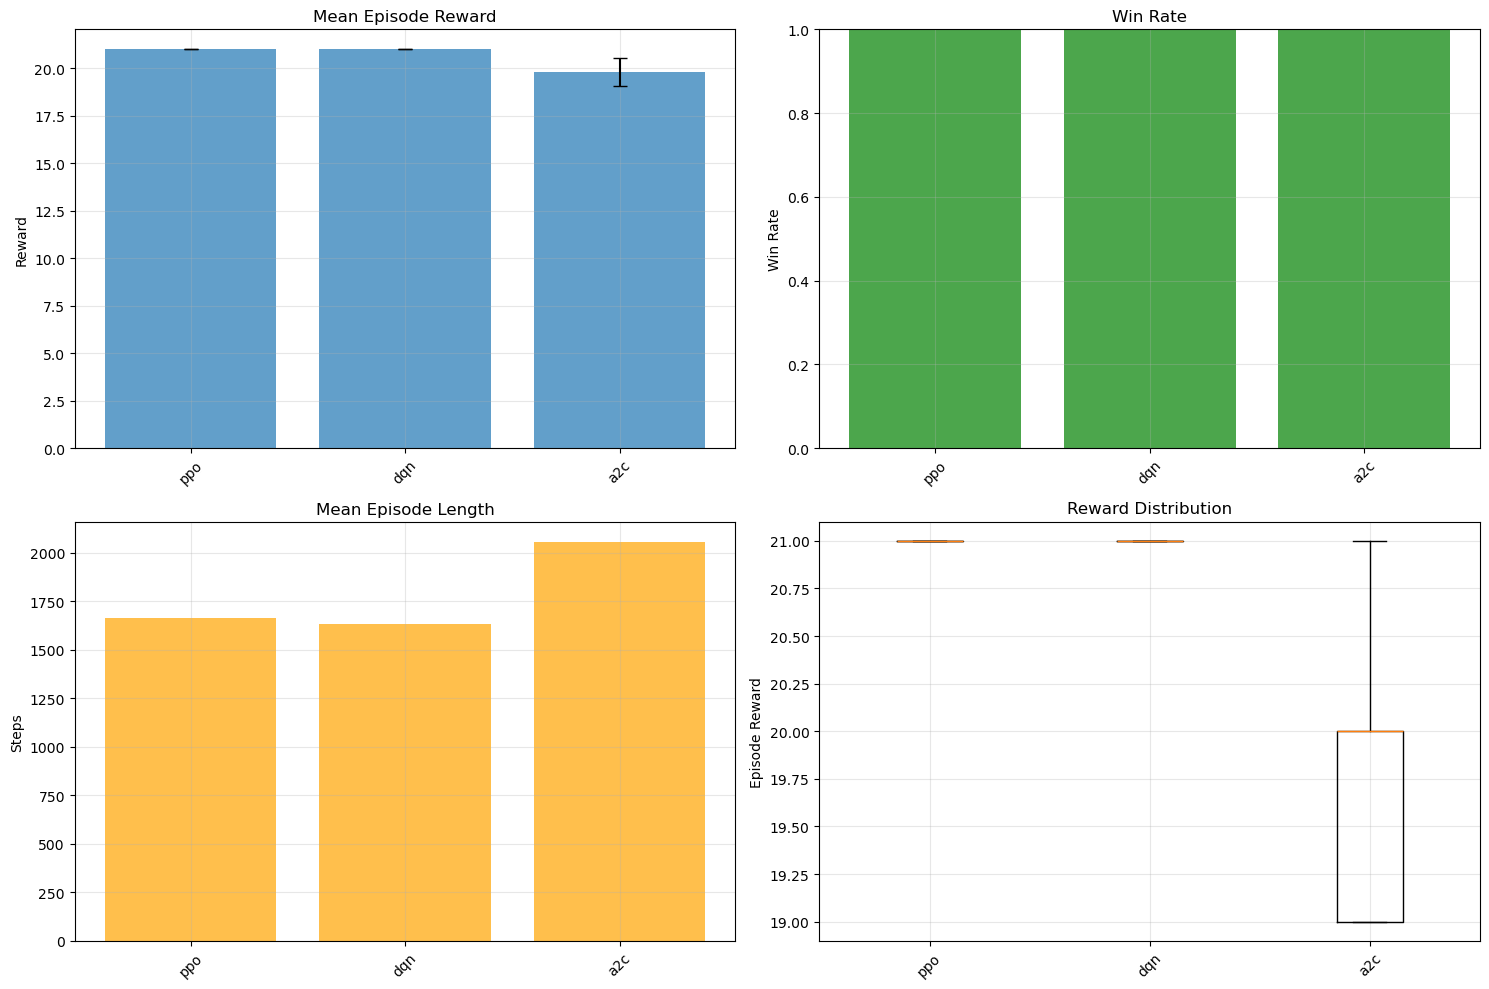

(32, 20, 20)


ipdb>  activations.shape


(500, 32, 20, 20)


ipdb>  n


> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(8)compute_rsa_matrix()
      6     import pdb; pdb.set_trace()
      7     if len(activations.shape) > 2:
----> 8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:
     10         activations_flat = activations



ipdb>  n


> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(13)compute_rsa_matrix()
     11 
     12     # Compute pairwise correlations
---> 13     rsa_matrix = np.corrcoef(activations_flat)
     14 
     15     return rsa_matrix



ipdb>  activations_flat.shape


(500, 12800)


ipdb>  n


> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(15)compute_rsa_matrix()
     13     rsa_matrix = np.corrcoef(activations_flat)
     14 
---> 15     return rsa_matrix
     16 
     17 def compare_matrices(behavioral_matrix, neural_matrix, method='pearson'):



ipdb>  rsa_matrix.shape


(500, 500)


ipdb>  exit


Error processing policy_features_cnn_0_Conv2d: 
  Processing value_features_cnn_0_Conv2d (shape: (500, 32, 20, 20))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_trace()
----> 7     if len(activations.shape) > 2:
      8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:



ipdb>  exit


Error processing value_features_cnn_0_Conv2d: 
  Processing shared_features_cnn_0_Conv2d (shape: (500, 32, 20, 20))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_trace()
----> 7     if len(activations.shape) > 2:
      8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:



ipdb>  exi


*** NameError: name 'exi' is not defined


ipdb>  exit


Error processing shared_features_cnn_0_Conv2d: 
  Processing policy_features_cnn_1_ReLU (shape: (500, 32, 20, 20))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_trace()
----> 7     if len(activations.shape) > 2:
      8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:



ipdb>  exit


Error processing policy_features_cnn_1_ReLU: 
  Processing value_features_cnn_1_ReLU (shape: (500, 32, 20, 20))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_trace()
----> 7     if len(activations.shape) > 2:
      8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:



ipdb>  exit


Error processing value_features_cnn_1_ReLU: 
  Processing shared_features_cnn_1_ReLU (shape: (500, 32, 20, 20))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_trace()
----> 7     if len(activations.shape) > 2:
      8         activations_flat = activations.reshape(activations.shape[0], -1)
      9     else:

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
    Pearson correlation: 0.0240 (p=0.0000)
    Spearman correlation: 0.0792 (p=0.0000)
    Similar group mean: 0.9865 ± 0.0428
    Dissimilar group mean: 0.9320 ± 0.0919
    Group difference p-value: 0.0000
  Processing policy_features_cnn_2_Conv2d (shape: (500, 64, 9, 9))
> /var/folders/w5/wtxn2_3x6jgbtxczqlsckq2r0000gp/T/ipykernel_97786/1641108451.py(7)compute_rsa_matrix()
      5     # Flatten activations if they're multi-dimensional
      6     import pdb; pdb.set_tra

KeyboardInterrupt: 

In [91]:
# Create enhanced evaluator with RSA capabilities
evaluator_rsa = ModelEvaluatorWithRSA(env_name="PongNoFrameskip-v4", render=False)

# Evaluate all models with simultaneous RSA collection
if 'models' in locals() and models:
    print("Starting comprehensive evaluation with RSA analysis...")
    print(f"Available models: {list(models.keys())}")
    
    # Run evaluation with RSA collection
    # Using fewer episodes but more states per episode for better RSA analysis
    comprehensive_results = evaluator_rsa.evaluate_all_models_with_rsa(
        models=models,
        num_episodes=5,  # Fewer episodes but more states collected per episode
        max_episode_length=10000,
        deterministic=True,
        max_states_for_rsa=5000  # Collect up to 500 states for RSA
    )
    
    if comprehensive_results:
        print(f"\nSuccessfully evaluated {len(comprehensive_results)} models")
        
        # Show standard performance comparison
        evaluator_rsa.compare_models()
        
        # Show RSA comparison across models
        evaluator_rsa.compare_rsa_across_models()
        
        # Plot performance (reuse existing method)
        evaluator_rsa.plot_performance()
    else:
        print("No models were successfully evaluated.")
else:
    print("No models available for evaluation. Please run the model download cell first.")

In [130]:
evaluator_rsa.rsa_results['ppo'].keys()

dict_keys(['policy_features_cnn_0_Conv2d', 'value_features_cnn_0_Conv2d', 'shared_features_cnn_0_Conv2d', 'policy_features_cnn_1_ReLU', 'value_features_cnn_1_ReLU', 'shared_features_cnn_1_ReLU', 'policy_features_cnn_2_Conv2d', 'value_features_cnn_2_Conv2d', 'shared_features_cnn_2_Conv2d', 'policy_features_cnn_3_ReLU', 'value_features_cnn_3_ReLU', 'shared_features_cnn_3_ReLU', 'policy_features_cnn_4_Conv2d', 'value_features_cnn_4_Conv2d', 'shared_features_cnn_4_Conv2d', 'policy_features_cnn_5_ReLU', 'value_features_cnn_5_ReLU', 'shared_features_cnn_5_ReLU', 'policy_features_cnn_6_Flatten', 'value_features_cnn_6_Flatten', 'shared_features_cnn_6_Flatten', 'policy_features_linear_0_Linear', 'value_features_linear_0_Linear', 'shared_features_linear_0_Linear', 'policy_features_linear_1_ReLU', 'value_features_linear_1_ReLU', 'shared_features_linear_1_ReLU', 'action_net_Linear', 'behavioral_matrix', 'logical_states', 'pixel_states', 'total_states_collected', 'sampled_indices'])

In [131]:
"action_net_Linear".split("policy_features_")

['action_net_Linear']

In [133]:
ppo_sims = {}
ppo_dsims = {}
toget = []
for key in evaluator_rsa.rsa_results['ppo'].keys():
    if 'policy_features' in key:
        toget.append(key)
toget.append("action_net_Linear")
for key in toget:
    try:
        effkey = key.split("policy_features_")[1]
    except:
        effkey = key
    simmean = evaluator_rsa.rsa_results['ppo'][key]['group_analysis']['similar_mean']
    simstd = evaluator_rsa.rsa_results['ppo'][key]['group_analysis']['similar_std']
    ppo_sims[effkey] = (simmean, simstd)
    dsimmean = evaluator_rsa.rsa_results['ppo'][key]['group_analysis']['dissimilar_mean']
    dsimstd = evaluator_rsa.rsa_results['ppo'][key]['group_analysis']['dissimilar_std']
    ppo_dsims[effkey] = (dsimmean, dsimstd)

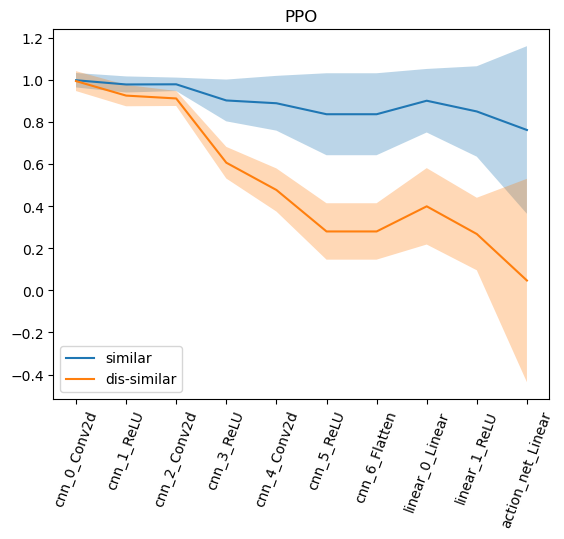

In [134]:
fig = plt.figure()
plt.plot([s[0] for s in ppo_sims.values()], label='similar')
plt.fill_between(range(len(ppo_sims)), [s[0] + s[1] for s in ppo_sims.values()], [s[0] - s[1] for s in ppo_sims.values()], alpha=0.3)
plt.plot([s[0] for s in ppo_dsims.values()], label='dis-similar')
plt.fill_between(range(len(ppo_dsims)), [s[0] + s[1] for s in ppo_dsims.values()], [s[0] - s[1] for s in ppo_dsims.values()], alpha=0.3)
plt.xticks(range(len(ppo_dsims)), ppo_dsims.keys(), rotation=70)
plt.legend()
plt.title("PPO")
fig.show()

In [135]:
dqn_sims = {}
dqn_dsims = {}
for key in evaluator_rsa.rsa_results['dqn'].keys():
    if 'q_features' in key:
        simmean = evaluator_rsa.rsa_results['dqn'][key]['group_analysis']['similar_mean']
        simstd = evaluator_rsa.rsa_results['dqn'][key]['group_analysis']['similar_std']
        dqn_sims[key.split("q_features_")[1]] = (simmean, simstd)
        dsimmean = evaluator_rsa.rsa_results['dqn'][key]['group_analysis']['dissimilar_mean']
        dsimstd = evaluator_rsa.rsa_results['dqn'][key]['group_analysis']['dissimilar_std']
        dqn_dsims[key.split("q_features_")[1]] = (dsimmean, dsimstd)

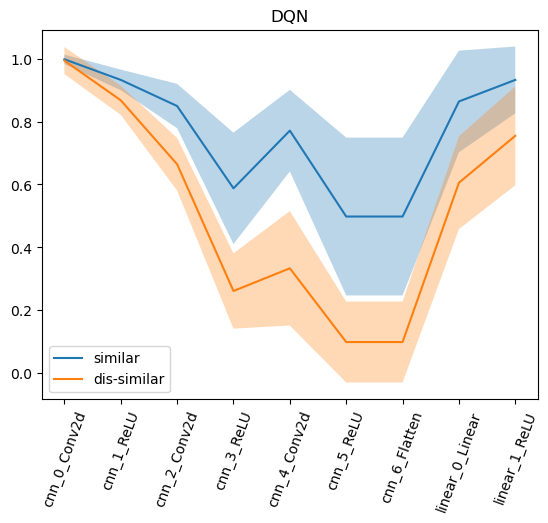

In [136]:
fig = plt.figure()
plt.plot([s[0] for s in dqn_sims.values()], label='similar')
plt.fill_between(range(len(dqn_sims)), [s[0] + s[1] for s in dqn_sims.values()], [s[0] - s[1] for s in dqn_sims.values()], alpha=0.3)
plt.plot([s[0] for s in dqn_dsims.values()], label='dis-similar')
plt.fill_between(range(len(dqn_dsims)), [s[0] + s[1] for s in dqn_dsims.values()], [s[0] - s[1] for s in dqn_dsims.values()], alpha=0.3)
plt.xticks(range(len(dqn_dsims)), dqn_dsims.keys(), rotation=70)
plt.legend()
plt.title("DQN")
fig.show()